In [ ]:
%pip install --upgrade itk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import itk
import urllib.request
import zipfile
import os

In [2]:
url = "https://data.kitware.com/api/v1/file/682629014ecc9b4265678aa6/download"
zip_path = "images/pet-ct.zip"
extract_dir = "images"

urllib.request.urlretrieve(url, zip_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

os.remove(zip_path)

In [3]:
ct_dir = os.path.join(extract_dir, "ct-pet", "CT CT WB wcontrast 5.0 B30s")
ct_image = itk.imread(ct_dir)
pt_dir = os.path.join(extract_dir, "ct-pet", "PT PET WB")
pt_image = itk.imread(pt_dir)

In [4]:
# Resample PT image to CT image space
InputImageType = type(pt_image)
OutputImageType = type(pt_image)

ResampleFilterType = itk.ResampleImageFilter[InputImageType, OutputImageType]
resampler = ResampleFilterType.New()
resampler.SetInput(pt_image)

resampler.SetOutputSpacing(ct_image.GetSpacing())
resampler.SetSize(ct_image.GetBufferedRegion().GetSize())
resampler.SetOutputOrigin(ct_image.GetOrigin())
resampler.SetOutputDirection(ct_image.GetDirection())

resampler.SetTransform(itk.IdentityTransform[itk.D, 3].New())
resampler.SetInterpolator(itk.LinearInterpolateImageFunction[InputImageType, itk.D].New())

resampler.Update()
pt_resampled = resampler.GetOutput()
pt_resampled

<itk.itkImagePython.itkImageD3; proxy of <Swig Object of type 'itkImageD3 *' at 0x000001A7EB768180> >

In [5]:
# Check if there are any non-zero values in the resampled PT image
import numpy as np

# Convert ITK image to numpy array
pt_array = itk.array_from_image(pt_resampled)

# Check for non-zero values
non_zero_count = np.count_nonzero(pt_array)
total_voxels = pt_array.size

# Calculate percentage of non-zero voxels
non_zero_percentage = (non_zero_count / total_voxels) * 100

print(f"Total voxels in resampled PT image: {total_voxels}")
print(f"Number of non-zero voxels: {non_zero_count} ({non_zero_percentage:.2f}%)")

if non_zero_count > 0:
    print("✅ PET and CT images have spatial overlap (non-zero values found in resampled PET image)")
else:
    print("❌ No spatial overlap between PET and CT images (all values are zero in resampled PET image)")
    print("Check the image origins, dimensions, and direction to ensure proper alignment.")


Total voxels in resampled PT image: 59244544
Number of non-zero voxels: 52507234 (88.63%)
✅ PET and CT images have spatial overlap (non-zero values found in resampled PET image)


In [6]:
# Combine ct_image and pt_resampled into a single 2-component float image
# Define the input and output image types explicitly
ImageType = itk.Image[itk.F, 3]
VectorImageType = itk.VectorImage[itk.F, 3]

# Cast both images to float
ct_image_float = itk.cast_image_filter(ct_image, ttype=(type(ct_image), ImageType))
pt_resampled_float = itk.cast_image_filter(pt_resampled, ttype=(type(pt_resampled), ImageType))

print("Images cast to float type")
print(f"CT image type: {type(ct_image_float)}")
print(f"PT image type: {type(pt_resampled_float)}")

# Check both images have the same dimensions
ct_size = ct_image_float.GetBufferedRegion().GetSize()
pt_size = pt_resampled_float.GetBufferedRegion().GetSize()
print(f"CT size: {ct_size}, PT size: {pt_size}")

# Use the ComposeImageFilter with explicit types to combine the images
ComposeFilterType = itk.ComposeImageFilter[ImageType, VectorImageType]
composer = ComposeFilterType.New()
composer.SetInput(0, ct_image_float)
composer.SetInput(1, pt_resampled_float)
composer.Update()
layered_image = composer.GetOutput()


Images cast to float type
CT image type: <class 'itk.itkImagePython.itkImageF3'>
PT image type: <class 'itk.itkImagePython.itkImageF3'>
CT size: itkSize3 ([512, 512, 226]), PT size: itkSize3 ([512, 512, 226])


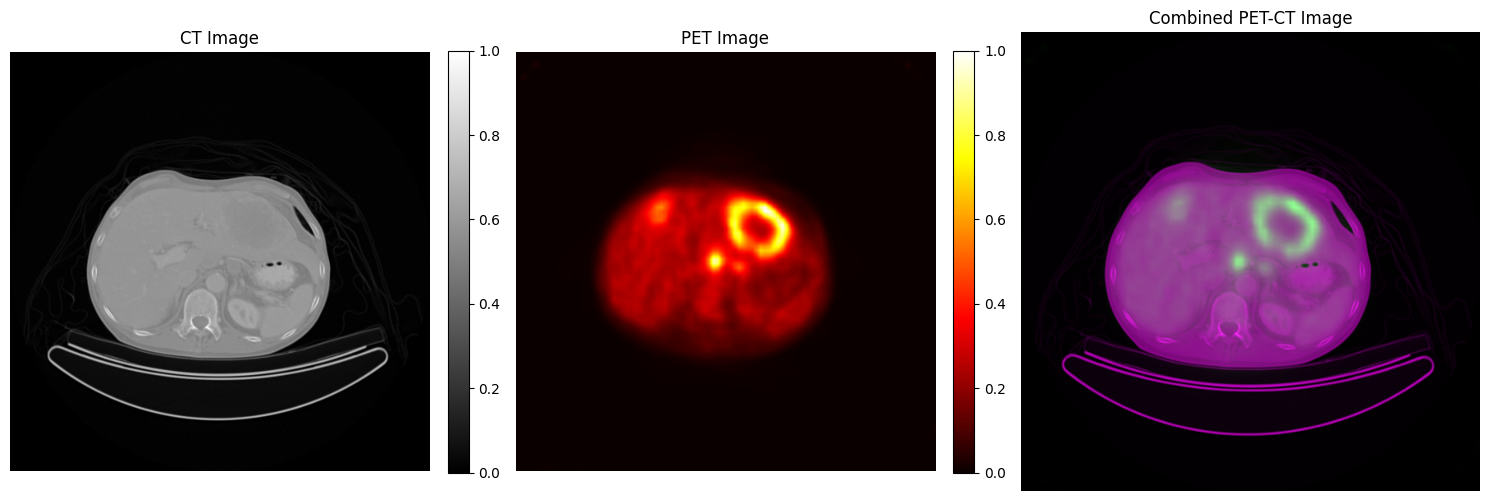

In [7]:
# Visualize the layered image using matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Extract data from the ITK image
layered_array = itk.array_from_image(layered_image)

# Get the middle slice for each component (CT and PET)
middle_slice_idx = layered_array.shape[0] // 2
ct_slice = layered_array[middle_slice_idx, :, :, 0]
pet_slice = layered_array[middle_slice_idx, :, :, 1]

# Normalize each modality for better visualization
def normalize_image(img):
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val > min_val:
        return (img - min_val) / (max_val - min_val)
    return img

ct_slice_norm = normalize_image(ct_slice)
pet_slice_norm = normalize_image(pet_slice)

# Create an RGB overlay (grayscale CT with colored PET overlay)
rgb_image = np.zeros((*ct_slice.shape, 3))
rgb_image[:, :, 0] = ct_slice_norm  # Red channel = CT
rgb_image[:, :, 1] = pet_slice_norm  # Green channel = PET
rgb_image[:, :, 2] = ct_slice_norm  # Blue channel = CT

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot CT image
im1 = axes[0].imshow(ct_slice_norm, cmap='gray')
axes[0].set_title('CT Image')
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot PET image
im2 = axes[1].imshow(pet_slice_norm, cmap='hot')
axes[1].set_title('PET Image')
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Plot combined image
im3 = axes[2].imshow(rgb_image)
axes[2].set_title('Combined PET-CT Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()